In [1]:
import pandas as pd
import scipy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

In [15]:
from constants import chemical_types
from constants import colors
from constants import experimental_deltaG
from bootstrap import bootstrap
import plotting

In [19]:
computational_deltaG_by_orientation = pd.read_csv("results/computational_deltaG_by_orientation.csv")
computational_deltaG_by_orientation.head()

,Unnamed: 0,system,smirnoff_fe,smirnoff_sem,bgbg_tip3p_fe,bgbg_tip3p_sem,guest_type
0,0,a-bam-p,-3.235478,0.451365,-0.016103,0.234765,aliphatic_ammoniums
1,1,a-bam-s,-0.543050,0.380773,-0.616992,0.270263,aliphatic_ammoniums
2,2,a-but-p,0.203689,0.298335,-0.335027,0.312059,aliphatic_carboxylates
3,3,a-but-s,-1.439269,0.287627,-0.846324,0.255411,aliphatic_carboxylates
4,4,a-cbu-p,-0.787973,0.289186,-0.264900,0.265886,cyclic_alcohols


## Combine each orientation for SMIRNOFF and GAFF, and then join with the experimental data.

```
combined_smirnoff = pd.DataFrame()

for hg in smirnoff_vs_bgbg["short_system"].unique():
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["smirnoff_fe"]
            primary_sem = row["smirnoff_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["smirnoff_fe"]
            secondary_sem = row["smirnoff_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_smirnoff = combined_smirnoff.append(pd.DataFrame({'system': hg,
                                 'smirnoff_fe' : results['mean'],
                                 'smirnoff_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)
```

In [21]:
computational_deltaG = pd.read_csv("results/computational_deltaG.csv")
computational_deltaG.head()

,Unnamed: 0,system,bgbg_tip3p_fe,bgbg_tip3p_sem,guest_type,smirnoff_fe,smirnoff_sem,exp_fe,exp_sem
0,0,a-bam,-0.816366,0.202997,aliphatic_ammoniums,-3.258327,0.436101,-1.58,0.02
1,1,a-but,-1.082174,0.212600,aliphatic_carboxylates,-1.478281,0.267168,-1.51,0.04
2,2,a-cbu,-0.882163,0.220704,cyclic_alcohols,-1.332480,0.184166,-2.02,0.02
3,3,a-chp,-1.705768,0.244498,cyclic_alcohols,-2.379730,0.288947,-2.51,0.06
4,4,a-coc,-1.841334,0.251879,cyclic_alcohols,-1.785875,0.290035,-3.23,1.14


## Plots

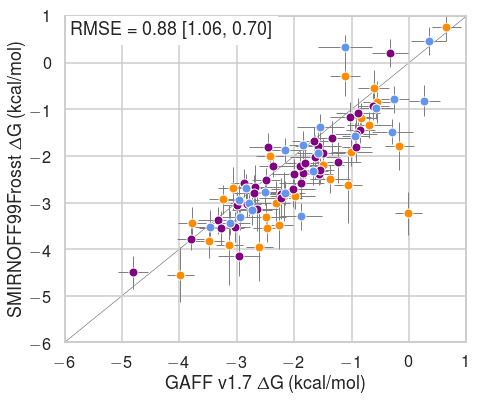

In [38]:
statistics = bootstrap(computational_deltaG_by_orientation["bgbg_tip3p_fe"],
                       computational_deltaG_by_orientation["bgbg_tip3p_sem"],
                       computational_deltaG_by_orientation["smirnoff_fe"],
                       computational_deltaG_by_orientation["smirnoff_sem"],
                       cycles=1000)

guest_types = computational_deltaG_by_orientation["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = computational_deltaG_by_orientation[computational_deltaG_by_orientation["guest_type"] == guest_type]
    ax.errorbar(
        tmp["bgbg_tip3p_fe"],
        tmp["smirnoff_fe"],
        xerr=tmp["bgbg_tip3p_sem"],
        yerr=tmp["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 1)
ax.set_xlim(-6, 1)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("GAFF v1.7 $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 1 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
plt.savefig("SMIRNOFF-vs-GAFF-deltaG.pdf")

Text(0.5,1,'Combined orientations')

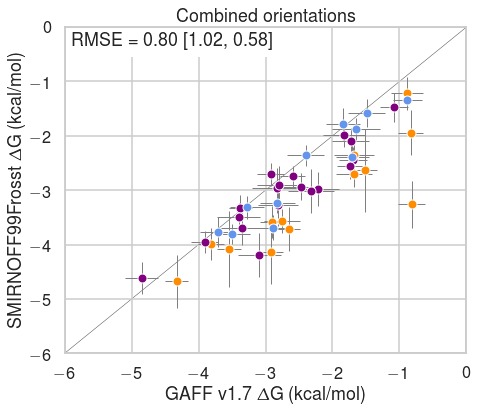

In [34]:
statistics = bootstrap(computational_deltaG["bgbg_tip3p_fe"],
                       computational_deltaG["bgbg_tip3p_sem"],
                       computational_deltaG["smirnoff_fe"],
                       computational_deltaG["smirnoff_sem"],
                       cycles=1000)

guest_types = computational_deltaG["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = computational_deltaG[computational_deltaG["guest_type"] == guest_type]
    ax.errorbar(
        tmp["bgbg_tip3p_fe"],
        tmp["smirnoff_fe"],
        xerr=tmp["bgbg_tip3p_sem"],
        yerr=tmp["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("GAFF v1.7 $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 0 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.set_title("Combined orientations")

In [23]:
computational_deltaG.head()

,Unnamed: 0,system,bgbg_tip3p_fe,bgbg_tip3p_sem,guest_type,smirnoff_fe,smirnoff_sem,exp_fe,exp_sem
0,0,a-bam,-0.816366,0.202997,aliphatic_ammoniums,-3.258327,0.436101,-1.58,0.02
1,1,a-but,-1.082174,0.212600,aliphatic_carboxylates,-1.478281,0.267168,-1.51,0.04
2,2,a-cbu,-0.882163,0.220704,cyclic_alcohols,-1.332480,0.184166,-2.02,0.02
3,3,a-chp,-1.705768,0.244498,cyclic_alcohols,-2.379730,0.288947,-2.51,0.06
4,4,a-coc,-1.841334,0.251879,cyclic_alcohols,-1.785875,0.290035,-3.23,1.14


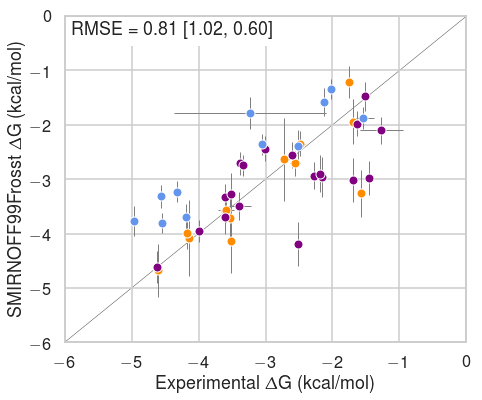

In [36]:
statistics = bootstrap(computational_deltaG["exp_fe"],
                       computational_deltaG["exp_sem"],
                       computational_deltaG["smirnoff_fe"],
                       computational_deltaG["smirnoff_sem"],
                       cycles=1000)

guest_types = computational_deltaG["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = computational_deltaG[computational_deltaG["guest_type"] == guest_type]
    ax.errorbar(
        tmp["exp_fe"],
        tmp["smirnoff_fe"],
        xerr=tmp["exp_sem"],
        yerr=tmp["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 0 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
plt.savefig("SMIRNOFF-vs-exp-deltaG.pdf")

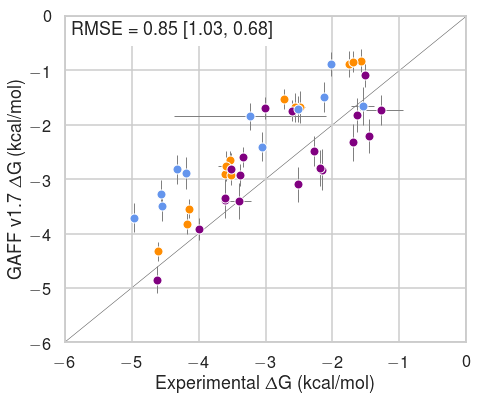

In [33]:
statistics = bootstrap(computational_deltaG["exp_fe"],
                       computational_deltaG["exp_sem"],
                       computational_deltaG["bgbg_tip3p_fe"],
                       computational_deltaG["bgbg_tip3p_sem"],
                       cycles=1000)

guest_types = computational_deltaG["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = computational_deltaG[computational_deltaG["guest_type"] == guest_type]
    ax.errorbar(
        tmp["exp_fe"],
        tmp["bgbg_tip3p_fe"],
        xerr=tmp["exp_sem"],
        yerr=tmp["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_ylabel("GAFF v1.7 $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 0 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
plt.savefig("GAFF-vs-exp-deltaG.pdf")